# A Simple Case Study using Wage Data from 2015

We illustrate how to predict an outcome variable Y in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have used linear prediction rules, e.g. Lasso regression, for estimation.
Now, we also consider nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [59]:
import pandas as pd
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import random
import itertools


import warnings
warnings.filterwarnings('ignore') # eliminar warning messages 

In [4]:
rdata_read = pyreadr.read_r("../../data/wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data = rdata_read[ 'data' ]

data.shape

(5150, 20)

In [5]:
data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
rownames,,,,,,,,,,,,,,,,,,,,
10,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
12,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
15,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
18,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
19,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32620,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9
32624,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
32626,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6


In [6]:
data = data.reset_index().drop( 'rownames', axis = 1)

In [7]:
data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
1,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
2,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
3,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
4,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9
5146,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
5147,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6
5148,32.967033,3.495508,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,1.00,1.000,1.0000,2920,9,6570,11


The outcomes $Y_i$'s are hourly (log) wages of never-married workers living in the U.S. The raw regressors $Z_i$'s consist of a variety of characteristics, including experience, education and industry and occupation indicators.

In [8]:
Z = data.loc[:, 'sex':'ind2']
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

The following figure shows the weekly wage distribution from the US survey data.

(0.0, 3000.0)

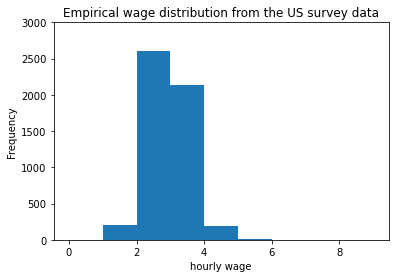

In [9]:
plt.hist(data.lwage , bins = np.arange(0, 10, 1) )
plt.xlabel('hourly wage')
plt.ylabel('Frequency')
plt.title( 'Empirical wage distribution from the US survey data' )
plt.ylim((0, 3000))

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$log(wage) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:
 
1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., ${exp}^2$ and ${exp}^3$) and additional two-way interactions.


To evaluate the out-of-sample performance, we split the data first.

In [10]:
nrow = data.shape[0]
length = int(nrow*(3/4))

In [11]:
from numpy.random import default_rng

random.seed(30)
rng = default_rng()

training = rng.choice(nrow, size = length, replace=False)

training_bool = data.index.isin( training )

data_train = data.iloc[training,:]

data_train = data[training_bool]
data_test = data[~training_bool]

In [12]:
data_train

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
2,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
4,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
5,11.730769,2.462215,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.01,0.001,0.0001,1650,5,7460,14
6,19.230769,2.956512,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,42.0,17.64,74.088,311.1696,5120,17,7280,14
7,19.230769,2.956512,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37.0,13.69,50.653,187.4161,5240,17,5680,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9
5146,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
5147,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6
5148,32.967033,3.495508,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,1.00,1.000,1.0000,2920,9,6570,11


In [13]:
data_train.shape

(3862, 20)

In [14]:
data_test.shape

(1288, 20)

We construct the two different model matrices $X_{basic}$ and $X_{flex}$ for both the training and the test sample:

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [16]:
formula_basic =  "lwage ~ sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
formula_flex = "lwage ~ sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"

y_basic_train, model_X_basic_train = patsy.dmatrices(formula_basic, data_train, return_type='dataframe')

In [17]:
model_X_basic_train

,Intercept,occ2[T.10],occ2[T.11],occ2[T.12],occ2[T.13],occ2[T.14],occ2[T.15],occ2[T.16],occ2[T.17],occ2[T.18],...,sex,exp1,exp2,shs,hsg,scl,clg,mw,so,we
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.0,3.24,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,22.0,4.84,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.01,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,42.0,17.64,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,37.0,13.69,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,9.0,0.81,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5146,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,12.0,1.44,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.0,1.21,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [18]:
formula_basic =  "lwage ~ sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
formula_flex = "lwage ~ sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"

y_basic_train, model_X_basic_train = patsy.dmatrices(formula_basic, data_train, return_type='dataframe')
y_basic_test, model_X_basic_test = patsy.dmatrices(formula_basic, data_test, return_type='dataframe')
p_basic = model_X_basic_train.shape[ 1 ]

y_flex_train, model_X_flex_train = patsy.dmatrices(formula_flex, data_train, return_type='dataframe')
y_flex_test, model_X_flex_test = patsy.dmatrices(formula_flex, data_test, return_type='dataframe')
p_flex = model_X_flex_train.shape[ 1 ]

In [19]:
print(p_basic)
print(p_flex)

52
246


In [20]:
Y_train = data_train['lwage']
Y_test = data_test['lwage']

As known from our first lab, the basic model consists of $52$ regressors and the flexible model of $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression. 

### OLS

We fit the basic model to our training data by running an ols regression and compute the mean squared error on the test sample.

In [21]:
# ols (basic model)
lm_basic = sm.OLS( Y_train, model_X_basic_train )
fit_lm_basic = lm_basic.fit()

# Compute the Out-Of-Sample Performance
yhat_lm_basic = fit_lm_basic.predict( model_X_basic_test )

print( f"The mean squared error (MSE) using the basic model is equal to , {np.mean((Y_test-yhat_lm_basic)**2)} ") # MSE OLS (basic model)    

The mean squared error (MSE) using the basic model is equal to , 0.23017847323352394 


To determine the out-of-sample $MSE$ and the standard error in one step, we can use the function *lm*:

In [22]:
resid_basic = (Y_test-yhat_lm_basic)**2

MSE_lm_basic = sm.OLS( resid_basic , np.ones( resid_basic.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_basic

Coef.       0.230178
Std.Err.    0.014598
Name: const, dtype: float64

We also compute the out-of-sample $R^2$:

In [23]:
R2_lm_basic = 1 - ( MSE_lm_basic[0]/Y_test.var() )
print( f"The R^2 using the basic model is equal to, {R2_lm_basic}" ) # MSE OLS (basic model) 

The R^2 using the basic model is equal to, 0.3069260893026915


We repeat the same procedure for the flexible model.

In [24]:
# ols (flex model)
lm_flex = sm.OLS( Y_train, model_X_flex_train )
fit_lm_flex = lm_flex.fit()

yhat_lm_flex = fit_lm_flex.predict( model_X_flex_test )

resid_flex = (Y_test-yhat_lm_flex)**2

MSE_lm_flex = sm.OLS( resid_flex , np.ones( resid_flex.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_flex

R2_lm_flex = 1 - ( MSE_lm_flex[0]/Y_test.var() )

print( f"The mean squared error (MSE) using theflexible model is equal to , {np.mean((Y_test-yhat_lm_flex)**2)} ") 
print( f"The R^2 using the flex model is equal to, {R2_lm_flex}" ) # MSE OLS (flex model) 

The mean squared error (MSE) using theflexible model is equal to , 0.24157716443729585 
The R^2 using the flex model is equal to, 0.2726043068247348


We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We are proceeding by running lasso regressions and its versions.

### Lasso, Ridge and Elastic Net


Considering the basic model, we run a lasso/post-lasso regression first and then we compute the measures for the out-of-sample performance. Note that applying the package *hdm* and the function *rlasso* we rely on a theoretical based choice of the penalty level $\lambda$ in the lasso regression.

In [25]:
import hdmpy

In [26]:
fit_rlasso = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

#### Estimating the predictions from rlasso models
We have to know that the residuals output come from this formula:

- x1 = x - np.ones( (x.shape[1] , 1) ) @ x.mean( axis = 0 )
- beta = model.est['beta'].loc[ fit_rlasso.est['index'].iloc[:, 0].to_list(), ].to_numpy()
- y1 = y - y.mean()
- yhat = x1 @ beta + y.mean()

So we have to apply those transfomations to original test data


In [27]:
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

In [28]:
np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T

array([[1.        , 0.05512422, 0.01552795, ..., 0.25698758, 0.30124224,
        0.21428571],
       [1.        , 0.05512422, 0.01552795, ..., 0.25698758, 0.30124224,
        0.21428571],
       [1.        , 0.05512422, 0.01552795, ..., 0.25698758, 0.30124224,
        0.21428571],
       ...,
       [1.        , 0.05512422, 0.01552795, ..., 0.25698758, 0.30124224,
        0.21428571],
       [1.        , 0.05512422, 0.01552795, ..., 0.25698758, 0.30124224,
        0.21428571],
       [1.        , 0.05512422, 0.01552795, ..., 0.25698758, 0.30124224,
        0.21428571]])

In [29]:
fit_rlasso.est['index'].iloc[:, 0].to_list()

[False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True]

In [30]:
fit_rlasso.est['beta'].loc[ fit_rlasso.est['index'].iloc[:, 0].to_list(), ]

,0
V2,0.034542
V3,-0.294708
V4,-0.102765
V5,-0.283330
V6,-0.305482
V7,-0.299721
V8,-0.044480
V9,-0.232245
V12,0.017072
V14,-0.057754


In [31]:
# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)


# Getting the significant variables
x1_est_rlasso = new_x1[ :, fit_rlasso.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso = fit_rlasso.est['beta'].loc[ fit_rlasso.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()



# yhat
yhat_rlasso = (x1_est_rlasso @ beta_rlasso) + np.mean( Y_test.to_numpy() )
residuals_rlasso = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso

In [32]:
# Post Lasso

# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post = new_x1[ :, fit_rlasso_post.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post = fit_rlasso_post.est['beta'].loc[ fit_rlasso_post.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post = (x1_est_rlasso_post @ beta_rlasso_post) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post

In [33]:
MSE_lasso = sm.OLS( ( residuals_rlasso )**2 , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ( residuals_rlasso_post )**2  , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)

R2_lasso = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post = 1 - MSE_lasso_post.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso},for lasso and {R2_lasso_post} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.2737783286122515,for lasso and 0.28583180033652955 for post-lasso


Now, we repeat the same procedure for the flexible model.

In [34]:
fit_rlasso_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

In [35]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_flex = new_x1[ :, fit_rlasso_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_flex = fit_rlasso_flex.est['beta'].loc[ fit_rlasso_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_flex = (x1_est_rlasso_flex @ beta_rlasso_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_flex

In [36]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post_flex = new_x1[ :, fit_rlasso_post_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post_flex = fit_rlasso_post_flex.est['beta'].loc[ fit_rlasso_post_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post_flex = (x1_est_rlasso_post_flex @ beta_rlasso_post_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post_flex

In [37]:
MSE_lasso_flex = sm.OLS( ( residuals_rlasso_flex )**2 , np.ones( yhat_rlasso_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post_flex = sm.OLS( ( residuals_rlasso_post_flex )**2  , np.ones( yhat_rlasso_post_flex.size )  ).fit().summary2().tables[1].round(3)

R2_lasso_flex = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post_flex = 1 - MSE_lasso_post_flex.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso_flex} for lasso and {R2_lasso_post_flex} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.2737783286122515 for lasso and 0.047775733782039254 for post-lasso


It is worth to notice that lasso regression works better for the more complex model.

In contrast to a theoretical based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet. In this context, we also run a ridge and a elastic net regression by adjusting the parameter *alpha*.

In [38]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV
import statsmodels.api as sm

In [39]:
Y_vec = Y_train.to_numpy().reshape( Y_train.to_numpy().size, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )

std_Y = scaler.transform( Y_vec )

std_Y 

array([[-1.01251074],
       [ 0.67502086],
       [-0.90851702],
       ...,
       [ 1.1813278 ],
       [ 0.91002984],
       [-0.22400826]])

In [40]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape(-1, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )  # mean and standar deviation
std_Y = scaler.transform( Y_vec )  # scale 

# Regressions
fit_lasso_cv_basic = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_basic_train, std_Y )

fit_ridge_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_basic_train , std_Y )
fit_elnet_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_basic_train , std_Y )



# Predictions

yhat_lasso_cv_basic = scaler.inverse_transform( fit_lasso_cv_basic.predict( model_X_basic_test ).reshape(-1, 1) )
yhat_ridge_basic = scaler.inverse_transform( fit_ridge_basic.predict( model_X_basic_test ).reshape(-1, 1) )
yhat_elnet_basic = scaler.inverse_transform( fit_elnet_basic.predict( model_X_basic_test ).reshape(-1, 1) )

In [41]:
MSE_lasso_cv_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_basic)**2 ) , np.ones( yhat_lasso_cv_basic.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_basic)**2 ) , np.ones( yhat_ridge_basic.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_basic)**2 ) , np.ones( yhat_elnet_basic.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [42]:
R2_lasso_cv_basic = 1- MSE_ridge_basic.iloc[0,0] / np.var( Y_test )
R2_ridge_basic = 1- MSE_lasso_cv_basic.iloc[0,0] / np.var( Y_test )
R2_elnet_basic = 1- MSE_elnet_basic.iloc[0,0] / np.var( Y_test )

In [43]:
print( f"R^2 using cross-validation for lasso, ridge and elastic net in the basic model: {R2_lasso_cv_basic},{R2_ridge_basic},{R2_elnet_basic}")

R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.0025752148159967625,0.3069253758540159,0.3069253758540159


In [44]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape( -1, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )
std_Y = scaler.transform( Y_vec )

# Regressions
fit_lasso_cv_flex = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_flex_train, std_Y )
fit_ridge_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_flex_train , std_Y )
fit_elnet_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_flex_train , std_Y )

# Predictions
yhat_lasso_cv_flex = scaler.inverse_transform( fit_lasso_cv_flex.predict( model_X_flex_test ).reshape(-1,1) )
yhat_ridge_flex = scaler.inverse_transform( fit_ridge_flex.predict( model_X_flex_test ).reshape(-1,1) )
yhat_elnet_flex = scaler.inverse_transform( fit_elnet_flex.predict( model_X_flex_test ).reshape(-1,1) )

In [45]:
MSE_lasso_cv_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_flex)**2 ) , np.ones( yhat_lasso_cv_flex.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_flex)**2 ) , np.ones( yhat_ridge_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_flex)**2 ) , np.ones( yhat_elnet_flex.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [46]:
R2_lasso_cv_flex = 1- MSE_ridge_flex.iloc[0,0] / np.var( Y_test )
R2_ridge_flex = 1- MSE_lasso_cv_flex.iloc[0,0] / np.var( Y_test )
R2_elnet_flex = 1- MSE_elnet_flex.iloc[0,0] / np.var( Y_test )

In [47]:
print( f"R^2 using cross-validation for lasso, ridge and elastic net in the basic model: {R2_lasso_cv_flex},{R2_ridge_flex},{R2_elnet_flex}")

R^2 using cross-validation for lasso, ridge and elastic net in the basic model: -0.0004381531150727813,0.30391200792294637,0.2737783286122515


The performance of the lasso regression with cross-validated penalty is quite similar to the performance of lasso using a theoretical based choice of the tuning parameter.

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are applying regression trees, random forests, boosted trees and neural nets to estimate the regression function $g(X)$. 


## Regression Trees

We fit a regression tree to the training data using the basic model. The variable *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from scipy.sparse import diags
from IPython.display import Image, display
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error

### scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [49]:
trees = DecisionTreeRegressor( random_state = 0 )

In [50]:
trees_fit =  trees.fit( model_X_basic_train, y_basic_train )

In [51]:
# What attributes save 

dir(trees_fit)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_prune_tree',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_X_predict',
 '_validate_data',
 'apply',
 'ccp_alpha',
 'class_weight',
 'cost_complexity_pruning_path',
 'criterion',
 'decision_path',
 'feature_importances_',
 'feature_names_in_',
 'fit',
 'get_depth',
 'get_n_leaves',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_

In [57]:
# some random tree atributes

print( trees_fit.get_depth() ) # tree's depth  

trees_fit.get_n_leaves() # number of leaves

38


3530

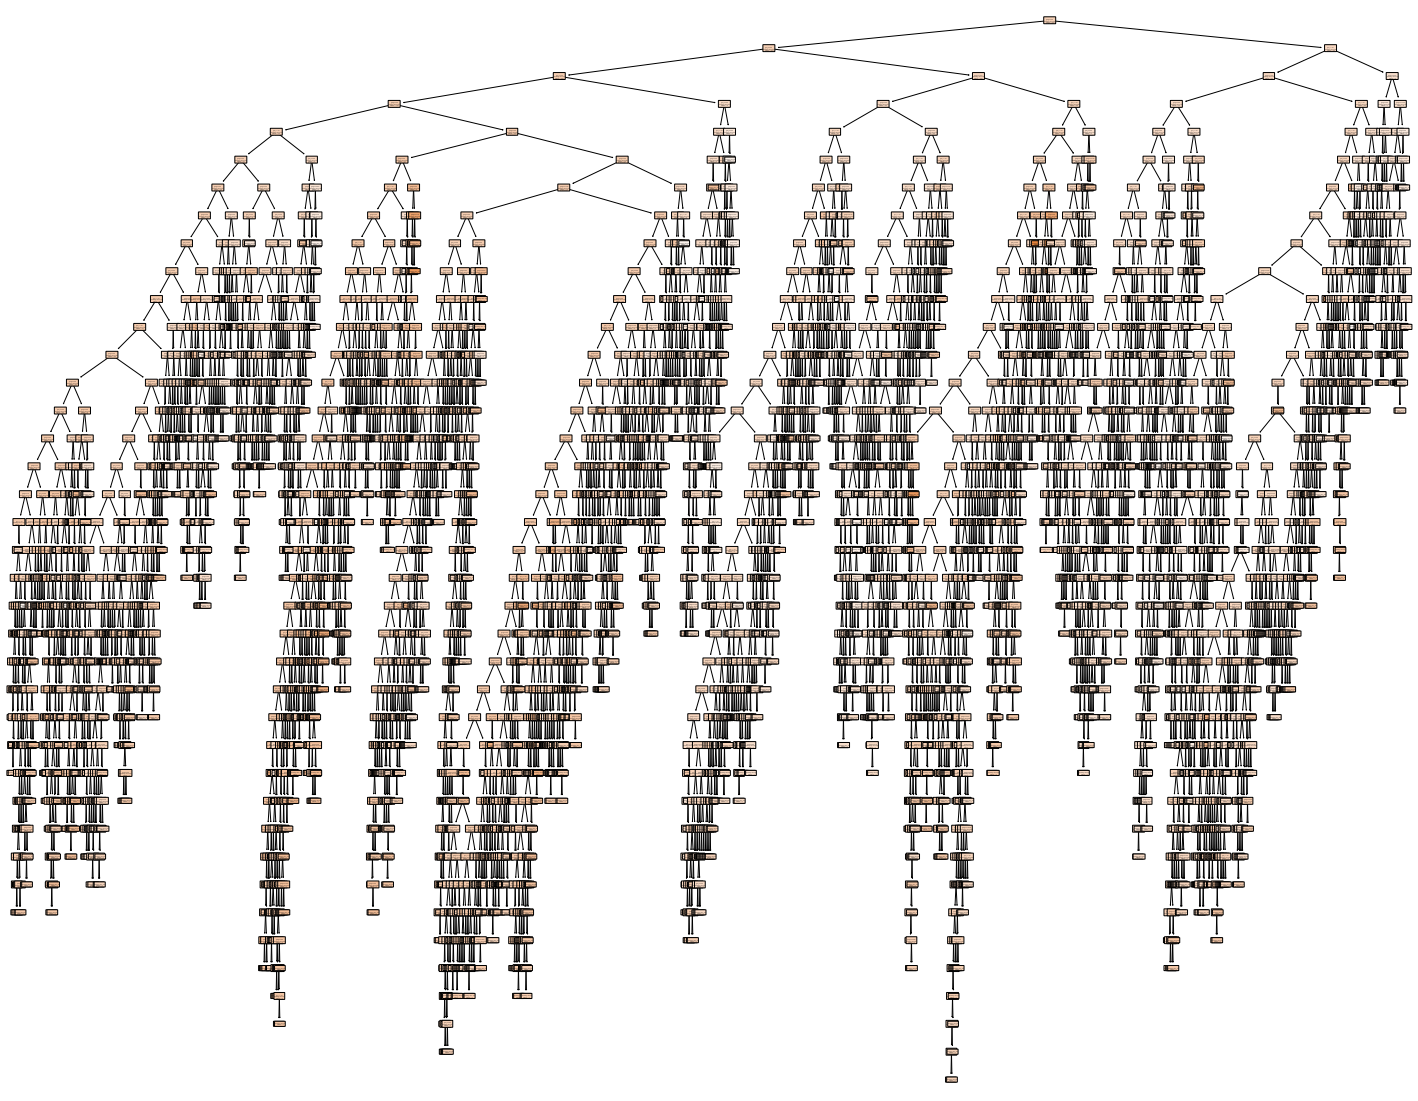

In [58]:
# tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree( trees_fit , filled = True , rounded = True  )

An important method to improve predictive performance is called "Pruning the Tree". This
means the process of cutting down the branches of a tree. We apply pruning to the complex tree above to reduce the depth. Initially, we determine the optimal complexity of the regression tree.

In [60]:
path = trees.cost_complexity_pruning_path( model_X_basic_train, y_basic_train  )
path

{'ccp_alphas': array([0.00000000e+00, 4.59957752e-19, 4.59957752e-19, ...,
        7.04737515e-03, 1.61505215e-02, 1.95127710e-02]),
 'impurities': array([0.01150832, 0.01150832, 0.01150832, ..., 0.28718451, 0.30333503,
        0.3228478 ])}

In [63]:
alphas_tree = pd.Series(path['ccp_alphas'], name = "alphas").unique()

alphas_tree

array([0.00000000e+00, 4.59957752e-19, 9.19915505e-19, ...,
       7.04737515e-03, 1.61505215e-02, 1.95127710e-02])

In [66]:
#Here we create a loop to get an arrange with all Mean Squared Errors for each cp_alpha

mse_gini = []
cp_table_size = []

for i in alphas_tree:
    dtree = DecisionTreeRegressor( ccp_alpha=i, random_state = 0)
    dtree.fit( model_X_basic_train, y_basic_train )
    pred = dtree.predict(model_X_basic_test)
    mse_gini.append(mean_squared_error( y_basic_test , pred))
    cp_table_size.append(dtree.tree_.node_count)

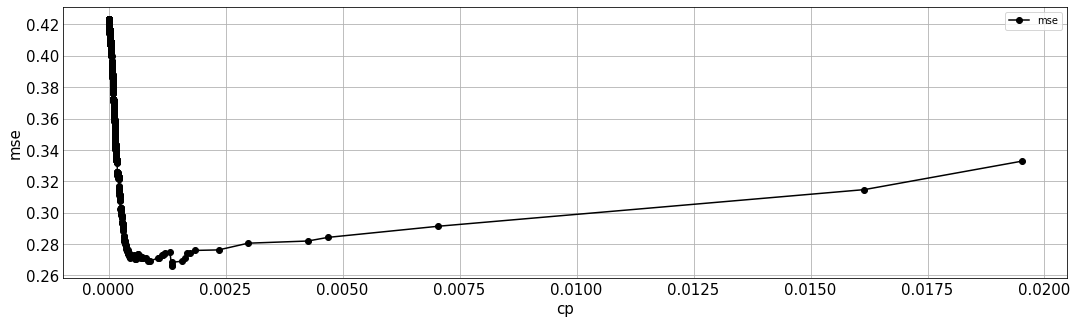

In [67]:
d2 = pd.DataFrame({'acc_gini':pd.Series(mse_gini),'ccp_alphas':pd.Series(alphas_tree)})

# visualizing changes in parameters

plt.figure(figsize=(18,5), facecolor = "white")
plt.plot('ccp_alphas','acc_gini', data=d2, label='mse', marker="o", color='black')

plt.tick_params( axis='x', labelsize=15, length=0, labelrotation=0)
plt.tick_params( axis='y', labelsize=15, length=0, labelrotation=0)
plt.grid()

plt.xlabel('cp', fontsize = 15)
plt.ylabel('mse', fontsize = 15)
plt.legend()

# the optimal cp - alpha reduces the MSE

In [68]:
#It is a function to get the best max_depth parametor with cross-validation
def prune_max_depth(X, y, nfold=10):
    cv_mean_mse = []
    max_depth = []
     # Num ob observations
    nobs = y.shape[0]
    
    # Define folds indices 
    list_1 = [*range(0, nfold, 1)]*nobs
    sample = np.random.choice(nobs,nobs, replace=False).tolist()
    foldid = [list_1[index] for index in sample]

    # Create split function(similar to R)
    def split(x, f):
        count = max(f) + 1
        return tuple( list(itertools.compress(x, (el == i for el in f))) for i in range(count) ) 

    # Split observation indices into folds 
    list_2 = [*range(0, nobs, 1)]
    I = split(list_2, foldid)
    
    for i in range(1,20):
        max_depth.append(i)
        mse_depth = []
        dtree = DecisionTreeRegressor( max_depth=i, random_state = 0)
        
        for b in range(0,len(I)):
            
            # Split data - index to keep are in mask as booleans
            include_idx = set(I[b])  #Here should go I[b] Set is more efficient, but doesn't reorder your elements if that is desireable
            mask = np.array([(a in include_idx) for a in range(len(y))])
            
            dtree.fit(X[~mask], y[~mask])
            pred = dtree.predict(X[mask])
            mse_depth.append(mean_squared_error(y[mask],pred))
            
        mse = np.mean(mse_depth)
        cv_mean_mse.append(mse)
    
    d1 = pd.DataFrame({'acc_depth':pd.Series(cv_mean_mse),'max_depth':pd.Series(max_depth)})
    return d1

In [70]:
# dataframe mse by each max_depth

d1 = prune_max_depth( model_X_basic_train, y_basic_train )

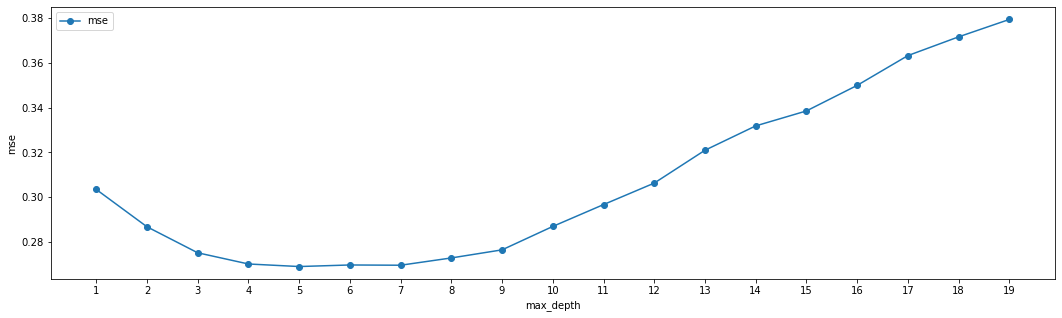

In [71]:
# visualizing changes in parameters
plt.figure(figsize=(18,5))
plt.plot('max_depth','acc_depth', data=d1, label='mse', marker="o")
plt.xticks(np.arange(1,20))

plt.xlabel('max_depth')
plt.ylabel('mse')
plt.legend()

In [73]:
# We get the best parameters

best_max_depth = d1[d1["acc_depth"] == np.min(d1["acc_depth"])].iloc[0,1]
best_ccp = d2[d2["acc_gini"] == np.min(d2["acc_gini"])].iloc[0,1]

# Prune the tree

dt = DecisionTreeRegressor(max_depth=best_max_depth , ccp_alpha= best_ccp , random_state=0)
tree1 = dt.fit( model_X_basic_train, y_basic_train )

[Text(0.65625, 0.9166666666666666, 'hsg <= 0.5\nsquared_error = 0.323\nsamples = 3862\nvalue = 2.978'),
 Text(0.4375, 0.75, 'scl <= 0.5\nsquared_error = 0.326\nsamples = 2922\nvalue = 3.058'),
 Text(0.3125, 0.5833333333333334, 'shs <= 0.5\nsquared_error = 0.317\nsamples = 1878\nvalue = 3.167'),
 Text(0.25, 0.4166666666666667, 'exp1 <= 5.5\nsquared_error = 0.299\nsamples = 1783\nvalue = 3.194'),
 Text(0.125, 0.25, 'occ2[T.17] <= 0.5\nsquared_error = 0.255\nsamples = 703\nvalue = 3.069'),
 Text(0.0625, 0.08333333333333333, 'squared_error = 0.252\nsamples = 637\nvalue = 3.1'),
 Text(0.1875, 0.08333333333333333, 'squared_error = 0.19\nsamples = 66\nvalue = 2.777'),
 Text(0.375, 0.25, 'clg <= 0.5\nsquared_error = 0.31\nsamples = 1080\nvalue = 3.276'),
 Text(0.3125, 0.08333333333333333, 'squared_error = 0.329\nsamples = 331\nvalue = 3.431'),
 Text(0.4375, 0.08333333333333333, 'squared_error = 0.287\nsamples = 749\nvalue = 3.207'),
 Text(0.375, 0.4166666666666667, 'squared_error = 0.371\nsamp

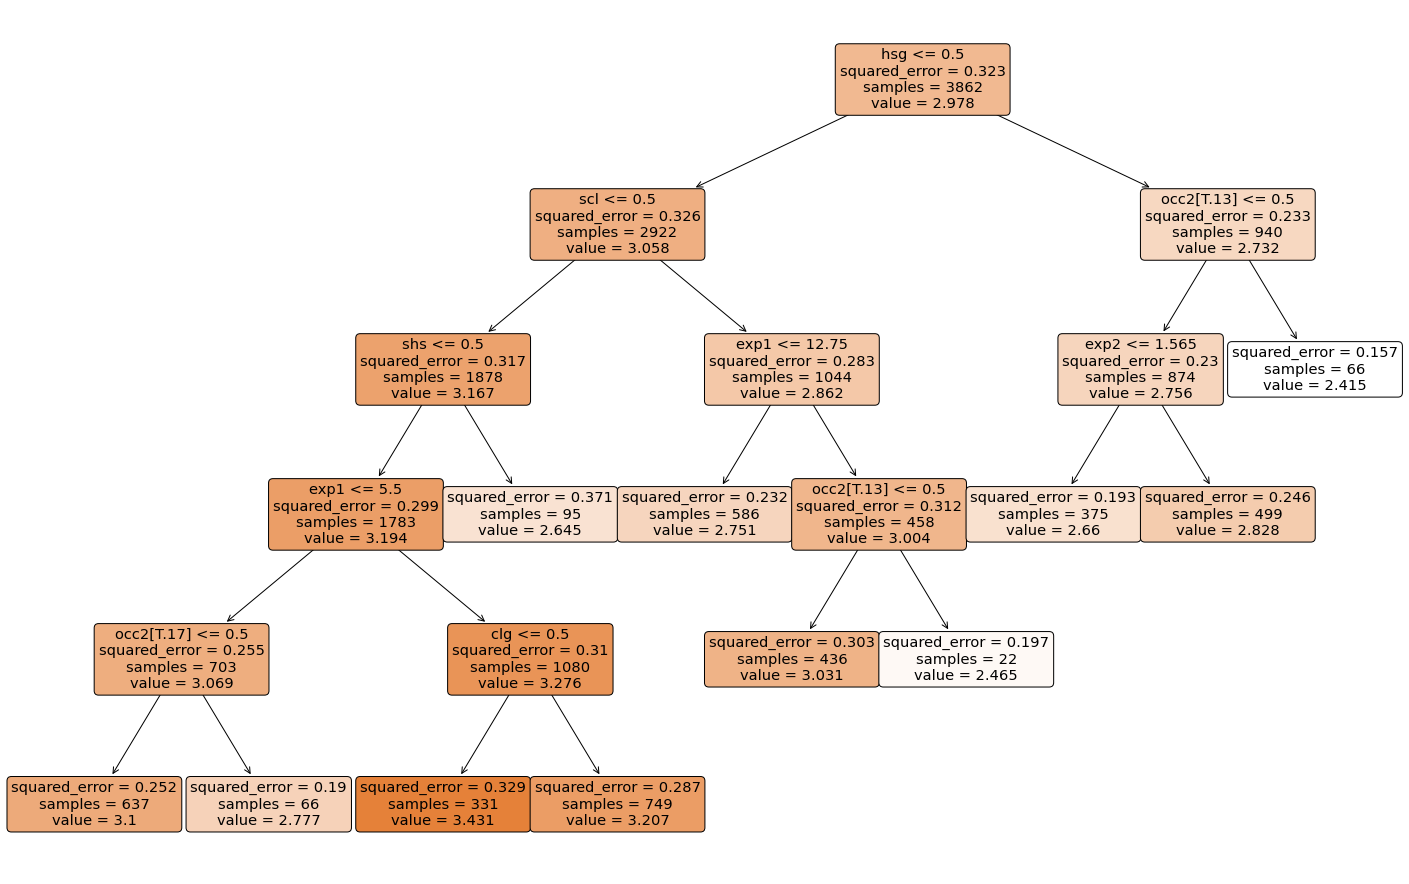

In [75]:
plt.figure(figsize=(25,16))
tree.plot_tree(dt, filled=True, rounded=True, feature_names = model_X_basic_train.columns)

In [76]:
y_hat_pt = dt.predict(model_X_basic_test)

MSE_pt= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_pt.reshape(-1,1))**2 ) , np.ones( y_hat_pt.shape )  ).fit().summary2().tables[1].round(3)
R2_pt = 1- MSE_pt.iloc[0,0] / np.var( Y_test )

print( f"R^2 using prune tree: {R2_pt}")

R^2 using prune tree: 0.18036392274909707


### Random Forest and Boosted Trees

In the next step, we apply the more advanced tree-based methods random forest and boosted trees.

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Sources:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [78]:
fit_rf = RandomForestRegressor( random_state = 0 , n_estimators = 500 , max_features = "sqrt" , n_jobs = 4 , min_samples_leaf = 5 ).fit( model_X_basic_train, y_basic_train )
fit_boost = GradientBoostingRegressor( random_state = 0 , n_estimators = 500 , max_features = p_basic , min_samples_leaf = 5 ).fit( model_X_basic_train, y_basic_train )

# N_estimators = number of trees

In [79]:
y_hat_rf = fit_rf.predict(model_X_basic_test)
y_hat_boost = fit_boost.predict(model_X_basic_test)

MSE_rf= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_rf.reshape(-1,1))**2 ) , np.ones( y_hat_rf.shape )  ).fit().summary2().tables[1].round(3)
R2_rf = 1- MSE_rf.iloc[0,0] / np.var( Y_test )

MSE_boost= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_boost.reshape(-1,1))**2 ) , np.ones( y_hat_boost.shape )  ).fit().summary2().tables[1].round(3)
R2_boost = 1- MSE_boost.iloc[0,0] / np.var( Y_test )

To conclude, let us have a look at our results.

## Results

In [80]:
table= np.zeros( (15, 3) )
table[0,0:2]   = MSE_lm_basic
table[1,0:2]   = MSE_lm_flex
table[2,0:2]   = MSE_lasso.iloc[0, [0, 1]]
table[3,0:2]   = MSE_lasso_post.iloc[0, [0, 1]]
table[4,0:2]   = MSE_lasso_flex.iloc[0, [0, 1]]
table[5,0:2]   = MSE_lasso_post_flex.iloc[0, [0, 1]]
table[6,0:2]   = MSE_lasso_cv_basic.iloc[0, [0, 1]]
table[7,0:2]   = MSE_ridge_basic.iloc[0, [0, 1]]
table[8,0:2]   = MSE_elnet_basic.iloc[0, [0, 1]]
table[9,0:2]   = MSE_lasso_cv_flex.iloc[0, [0, 1]]
table[10,0:2]  = MSE_ridge_flex.iloc[0, [0, 1]]
table[11,0:2]  = MSE_elnet_flex.iloc[0, [0, 1]]
table[12,0:2]  = MSE_rf.iloc[0, [0, 1]]
table[13,0:2]  = MSE_boost.iloc[0, [0, 1]]
table[14,0:2]  = MSE_pt.iloc[0, [0, 1]]



table[0,2]   = R2_lm_basic
table[1,2]   = R2_lm_flex
table[2,2]   = R2_lasso
table[3,2]   = R2_lasso_post
table[4,2]   = R2_lasso_flex
table[5,2]   = R2_lasso_post_flex
table[6,2]   = R2_lasso_cv_basic
table[7,2]   = R2_ridge_basic
table[8,2]   = R2_elnet_basic
table[9,2]   = R2_lasso_cv_flex
table[10,2]  = R2_ridge_flex
table[11,2]  = R2_elnet_flex
table[12,2]  = R2_rf
table[13,2]  = R2_boost
table[14,2]  = R2_pt




colnames_table= ["MSE", "S_E_ for MSE", "R-squared"]
rownames_table= ["Least Squares (basic)","Least Squares (flexible)", "Lasso", "Post-Lasso","Lasso (flexible)","Post-Lasso (flexible)", \
                    "Cross-Validated lasso", "Cross-Validated ridge","Cross-Validated elnet","Cross-Validated lasso (flexible)","Cross-Validated ridge (flexible)","Cross-Validated elnet (flexible)",  \
                    "Random Forest","Boosted Trees", "Pruned Tree"]
table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round(3)
table_html = table_pandas.to_latex()
table_pandas

,MSE,S_E_ for MSE,R-squared
Least Squares (basic),0.230,0.015,0.307
Least Squares (flexible),0.242,0.014,0.273
Lasso,0.241,0.015,0.274
Post-Lasso,0.237,0.015,0.286
Lasso (flexible),0.242,0.015,0.274
Post-Lasso (flexible),0.316,0.056,0.048
Cross-Validated lasso,0.230,0.015,0.003
Cross-Validated ridge,0.331,0.016,0.307
Cross-Validated elnet,0.230,0.015,0.307
Cross-Validated lasso (flexible),0.231,0.014,-0.000


Above, we displayed the results for a single split of data into the training and testing part. The table shows the test MSE in column 1 as well as the standard error in column 2 and the test $R^2$
in column 3. We see that the prediction rule produced by Elastic Net using the flexible model performs the best here, giving the lowest test MSE. Cross-Validated Lasso and Ridge, perform nearly as well. For any two of these methods, their testing MSEs are within one standard error of each other. Remarkably, OLS on a simple model performs extremely well, almost as well as best tree based method Random Forest. On the other hand, OLS on a flexible model with many regressors performs very poorly giving the highest test MSE. It is worth to notice that the nonlinear models, e.g. Random Forest, are not tuned. Thus, there is a lot of potential to improve the performance of the nonlinear methods we used in the analysis.

### References

https://patsy.readthedocs.io/en/latest/API-reference.html